In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#All from other notebook
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram, plot_bloch_multivector

backend = Aer.get_backend('qasm_simulator')

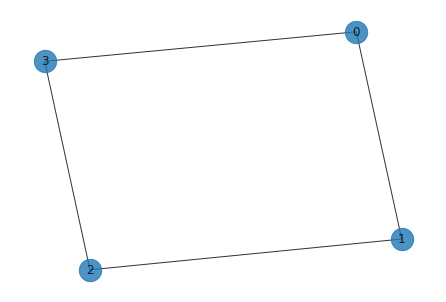

In [4]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3,0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

/var/folders/zp/sxlwjn2x4x19skyg902xnrsc0000gn/T/ipykernel_86518/1379068234.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


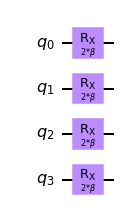

In [5]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

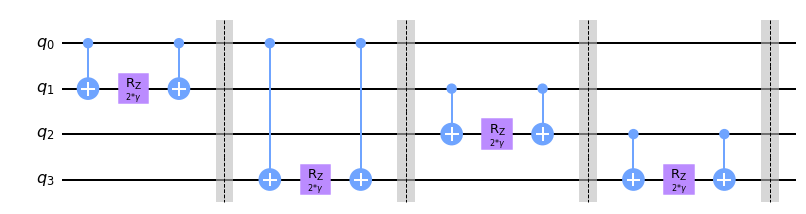

In [6]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw('mpl')


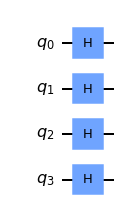

In [7]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

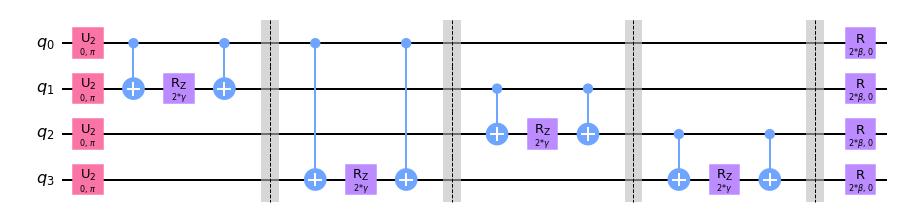

In [8]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw('mpl')

In [9]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    #print('theta: ', theta)
    #print('p: ', p)
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    #extra start
    print('beta: ', beta)
    print('gamma: ', gamma)
    ##extra done
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
#    backend = Aer.get_backend('aer_simulator')
    backend.shots = shots
    
   
    
    return execute_circ

In [10]:
from scipy.optimize import minimize


expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')                  
res 

beta:  [1.]
gamma:  [1.]
beta:  [2.]
gamma:  [1.]
beta:  [2.]
gamma:  [2.]
beta:  [2.60303802]
gamma:  [0.20228755]
beta:  [2.30151901]
gamma:  [0.60114378]
beta:  [1.76178091]
gamma:  [0.92416026]
beta:  [2.05221827]
gamma:  [1.24448569]
beta:  [2.2970623]
gamma:  [1.29499708]
beta:  [1.93619298]
gamma:  [1.2909952]
beta:  [2.02948649]
gamma:  [1.18626614]
beta:  [2.00948701]
gamma:  [1.12705237]
beta:  [2.05859626]
gamma:  [1.17490025]
beta:  [1.97179854]
gamma:  [1.16221722]
beta:  [1.91643964]
gamma:  [1.19122829]
beta:  [1.95648584]
gamma:  [1.10162208]
beta:  [1.99394406]
gamma:  [1.18426576]
beta:  [1.97337986]
gamma:  [1.14667244]
beta:  [1.95870223]
gamma:  [1.17073939]
beta:  [1.97605962]
gamma:  [1.16876537]
beta:  [1.98032071]
gamma:  [1.17531353]
beta:  [1.9793337]
gamma:  [1.16663483]
beta:  [1.98709616]
gamma:  [1.16575202]
beta:  [1.97764907]
gamma:  [1.16311051]
beta:  [1.98099017]
gamma:  [1.16766962]
beta:  [1.97912184]
gamma:  [1.16568152]
beta:  [1.97869796]
gamma:

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.994140625
       x: [ 1.979e+00  1.167e+00]
    nfev: 30
   maxcv: 0.0

beta:  [1.9793337]
gamma:  [1.16663483]


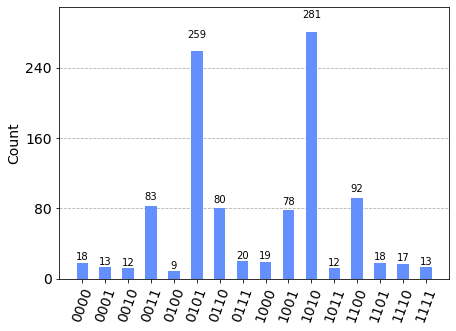

In [11]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)